In [1]:
%reset -f
import pandas_datareader as pd_data
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import seaborn as sns
import math as m
import scipy as sp
from statsmodels.stats.anova import anova_lm
import yfinance as yf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import arma_order_select_ic

In [2]:
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import arma_order_select_ic
import statsmodels.tsa.stattools as sm_tools

# Getting Data

In [3]:
start_date = '2019-09-01'
end_date = '2021-09-01'

SW = yf.download("LUV", start_date , end_date)  #Southwest airlines

[*********************100%***********************]  1 of 1 completed


In [4]:
NF = yf.download("NFLX", start_date , end_date) #Netflix

[*********************100%***********************]  1 of 1 completed


In [5]:
SW

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-09-03,51.889999,52.240002,50.910000,51.380001,51.016926,4297988
2019-09-04,51.830002,52.290001,51.009998,52.099998,51.731838,3166998
2019-09-05,52.599998,53.130001,52.439999,52.520000,52.148872,3236445
2019-09-06,52.750000,53.150002,52.080002,52.139999,51.771557,2773605
2019-09-09,52.139999,53.294998,51.820000,53.080002,52.704914,3127554
...,...,...,...,...,...,...
2021-08-25,50.840000,52.018002,50.330002,51.250000,51.250000,8039508
2021-08-26,50.930000,51.299999,49.830002,50.270000,50.270000,5779400
2021-08-27,50.310001,51.340000,50.310001,50.880001,50.880001,5940878


In [6]:
NF

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-09-03,290.820007,293.899994,288.059998,289.290009,289.290009,3684177
2019-09-04,291.250000,292.380005,286.510010,291.519989,291.519989,4653665
2019-09-05,285.320007,293.970001,282.785004,293.250000,293.250000,8972356
2019-09-06,293.350006,293.350006,287.029999,290.170013,290.170013,5166556
2019-09-09,294.809998,301.549988,290.600006,294.339996,294.339996,8232744
...,...,...,...,...,...,...
2021-08-25,550.159973,552.840027,545.450012,547.580017,547.580017,2065621
2021-08-26,546.159973,552.604004,545.900024,550.119995,550.119995,1595499
2021-08-27,551.599976,564.169983,549.250000,558.919983,558.919983,3252595


In [7]:
sw = SW['Close']
nf = NF['Close']

Text(77.875, 0.5, 'Netflix Price')

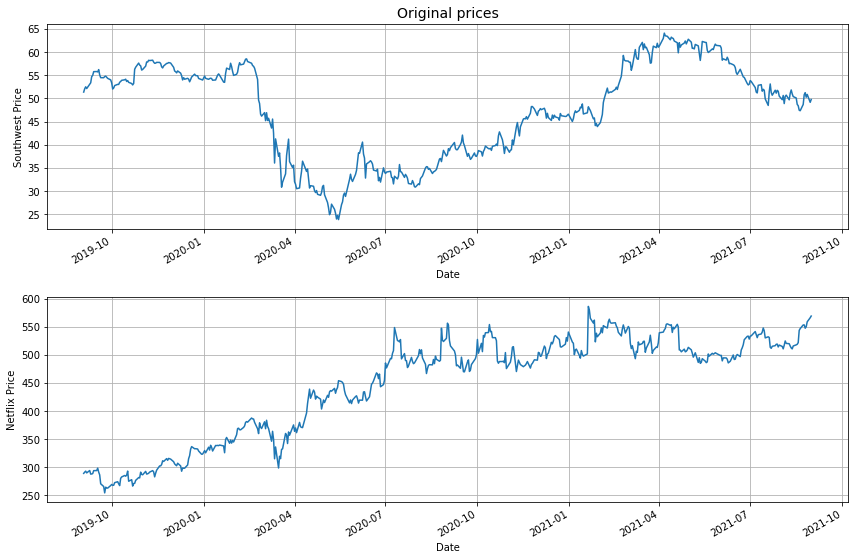

In [8]:
plt.figure(figsize=(12,8))

plt.subplot(2,1, 1)
sw.plot()
plt.grid()
plt.ylabel("Southwest Price")
plt.title("Original prices", fontsize = 14)
plt.subplot(2,1, 2)
nf.plot()
plt.grid()
plt.tight_layout(pad=1.5)
plt.ylabel("Netflix Price")

# ARIMA 

In [9]:
sw_rtn = np.log(sw).diff().dropna()

Text(66.25, 0.5, 'Daily Log Returns')

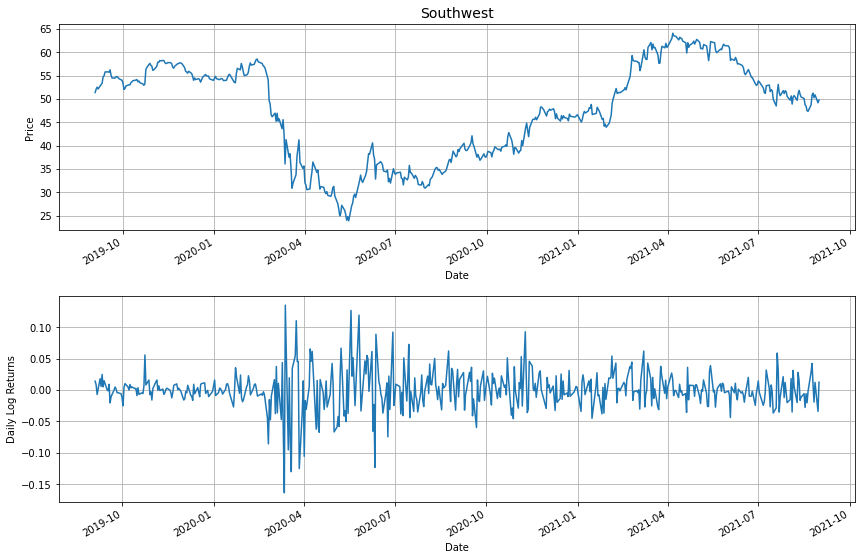

In [10]:
plt.figure(figsize=(12,8))

plt.subplot(2,1, 1)
sw.plot()
plt.grid()
plt.ylabel("Price")
plt.title("Southwest", fontsize = 14)
plt.subplot(2,1, 2)
sw_rtn.plot()
plt.grid()
plt.tight_layout(pad=1.5)
plt.ylabel("Daily Log Returns")

In [11]:
nf_rtn = np.log(nf).diff().dropna()

Text(66.25, 0.5, 'Daily Log Returns')

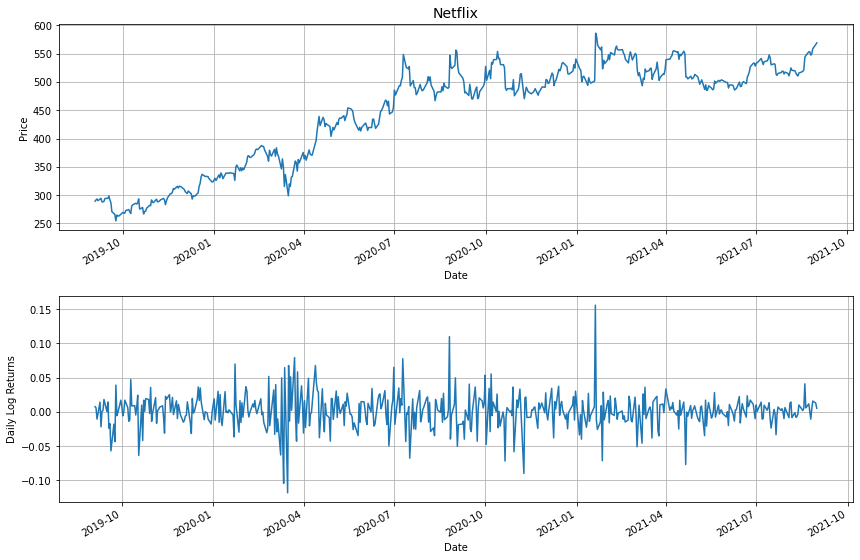

In [12]:
plt.figure(figsize=(12,8))

plt.subplot(2,1, 1)
nf.plot()
plt.grid()
plt.ylabel("Price")
plt.title("Netflix", fontsize = 14)
plt.subplot(2,1, 2)
nf_rtn.plot()
plt.grid()
plt.tight_layout(pad=1.5)
plt.ylabel("Daily Log Returns")

# Exploring Differencing

In [13]:
def plot_diagnosticsTight2(data, rtn, title1):

    fig, axes = plt.subplots(1,2,figsize=(15,5))
    axes[0].set_ylabel('ACF', fontsize=15)
    axes[0].set_xlabel('Lag', fontsize=15)
    fig = plot_acf(data,lags=25,zero=True, ax = axes[0], title= 'ACF '+ title1, use_vlines = True)
    axes[1].set_ylabel('ACF', fontsize=15)
    axes[1].set_xlabel('Lag', fontsize=15)
    fig = plot_acf(rtn,lags=25,zero=True, ax = axes[1], title= 'ACF Log Returns '+ title1, use_vlines = True)
    plt.tight_layout()

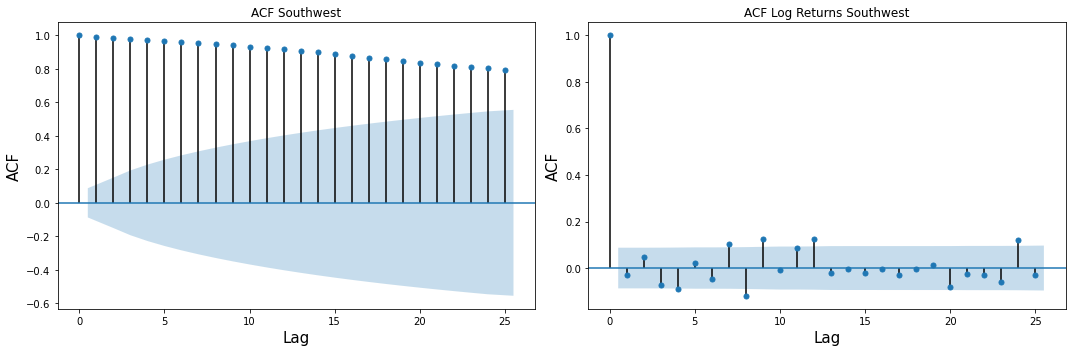

In [14]:
plot_diagnosticsTight2(sw, sw_rtn,title1 = 'Southwest')

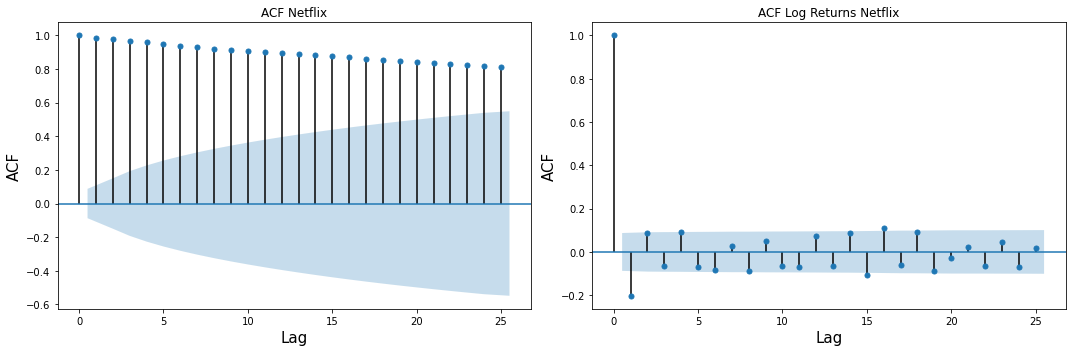

In [15]:
plot_diagnosticsTight2(nf, nf_rtn,title1 = 'Netflix')

# Southwest Dataset First

In [16]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(sw.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])   #P-value is greater than the significance level, need difference

ADF Statistic: -1.685798
p-value: 0.438444


In [17]:
result = adfuller(sw_rtn.dropna())  # 1st difference
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])   #P-value is smaller than the significance level, can apply ARMA now

ADF Statistic: -5.132184
p-value: 0.000012


## Train Test Slip

In [90]:
sw

Date
2019-09-03    51.380001
2019-09-04    52.099998
2019-09-05    52.520000
2019-09-06    52.139999
2019-09-09    53.080002
                ...    
2021-08-25    51.250000
2021-08-26    50.270000
2021-08-27    50.880001
2021-08-30    49.169998
2021-08-31    49.779999
Name: Close, Length: 504, dtype: float64

In [104]:
train = sw.iloc[:403]
test = sw.iloc[403:]
test

Date
2021-04-09    63.419998
2021-04-12    62.660000
2021-04-13    63.230000
2021-04-14    63.029999
2021-04-15    62.939999
                ...    
2021-08-25    51.250000
2021-08-26    50.270000
2021-08-27    50.880001
2021-08-30    49.169998
2021-08-31    49.779999
Name: Close, Length: 101, dtype: float64

## ARIMA

In [105]:
train_rtn = np.log(train).diff().dropna()
test_rtn = np.log(test).diff().dropna()

In [106]:
best_model = arma_order_select_ic(train_rtn, max_ar = 3, max_ma =3, ic=['aic', 'bic'])
print('AIC Best: ',best_model.aic_min_order)
print('BIC Best: ',best_model.bic_min_order)

AIC Best:  (0, 0)
BIC Best:  (0, 0)


### ARIMA(0,1,0) on log transformed data

In [107]:
train_log = np.log(train).dropna()
test_log = np.log(test).dropna()

In [108]:
model = ARIMA(train_log, order=(0,1,0))
ARIMA010 = model.fit()
print(ARIMA010.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  402
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 801.275
Method:                           css   S.D. of innovations              0.033
Date:                Mon, 13 Dec 2021   AIC                          -1598.550
Time:                        12:03:41   BIC                          -1590.557
Sample:                             1   HQIC                         -1595.386
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.002      0.319      0.749      -0.003       0.004


C:\Users\11638\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\11638\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


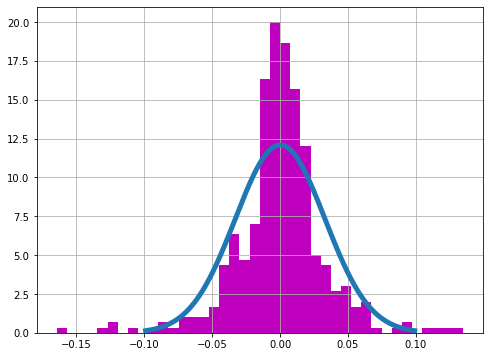

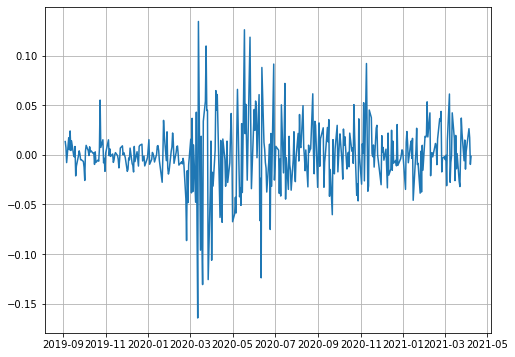

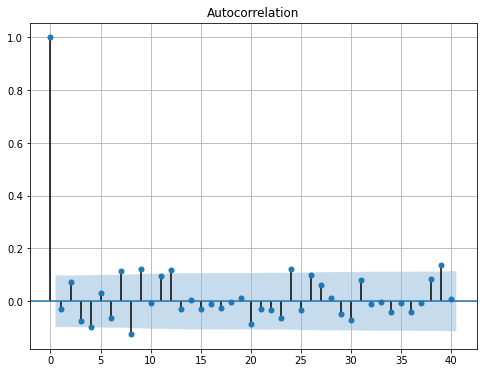

In [133]:
resid = ARIMA010.resid
plt.hist(resid, bins =40,color='m', density = True)
mu = resid.mean()
sigma = resid.std()
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 2419)
plt.plot(x, stats.norm.pdf(x, mu, sigma), linewidth= 5)
plt.grid()
plt.show()
plt.plot(resid)
plt.grid()
plt.show()
plot_acf(resid,lags=40,zero=True)
plt.grid()
plt.show()

### Compare with other ARIMA models

In [130]:
model = ARIMA(train_log, order=(1,1,0))
ARIMA110 = model.fit()
print(ARIMA110.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  402
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 801.463
Method:                       css-mle   S.D. of innovations              0.033
Date:                Mon, 13 Dec 2021   AIC                          -1596.926
Time:                        13:09:53   BIC                          -1584.936
Sample:                             1   HQIC                         -1592.179
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0005      0.002      0.329      0.742      -0.003       0.004
ar.L1.D.Close    -0.0305      0.050     -0.613      0.540      -0.128       0.067
                                    Root

C:\Users\11638\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\11638\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


In [131]:
model = ARIMA(train_log, order=(0,1,1))
ARIMA011 = model.fit()
print(ARIMA011.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  402
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 801.440
Method:                       css-mle   S.D. of innovations              0.033
Date:                Mon, 13 Dec 2021   AIC                          -1596.880
Time:                        13:10:27   BIC                          -1584.891
Sample:                             1   HQIC                         -1592.133
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0005      0.002      0.328      0.743      -0.003       0.004
ma.L1.D.Close    -0.0269      0.047     -0.573      0.566      -0.119       0.065
                                    Root

C:\Users\11638\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\11638\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


In [132]:
model = ARIMA(train_log, order=(1,1,1))
ARIMA111 = model.fit()
print(ARIMA111.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  402
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 801.913
Method:                       css-mle   S.D. of innovations              0.033
Date:                Mon, 13 Dec 2021   AIC                          -1595.825
Time:                        13:10:53   BIC                          -1579.839
Sample:                             1   HQIC                         -1589.496
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0005      0.002      0.330      0.741      -0.003       0.004
ar.L1.D.Close    -0.4835      0.270     -1.788      0.074      -1.013       0.046
ma.L1.D.Close     0.4342      0.275     

C:\Users\11638\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\11638\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


#### Other orders of AR and MA seem unnecessary and do not have as good AIC or BIC as ARIMA(0,1,0)

### Prediction

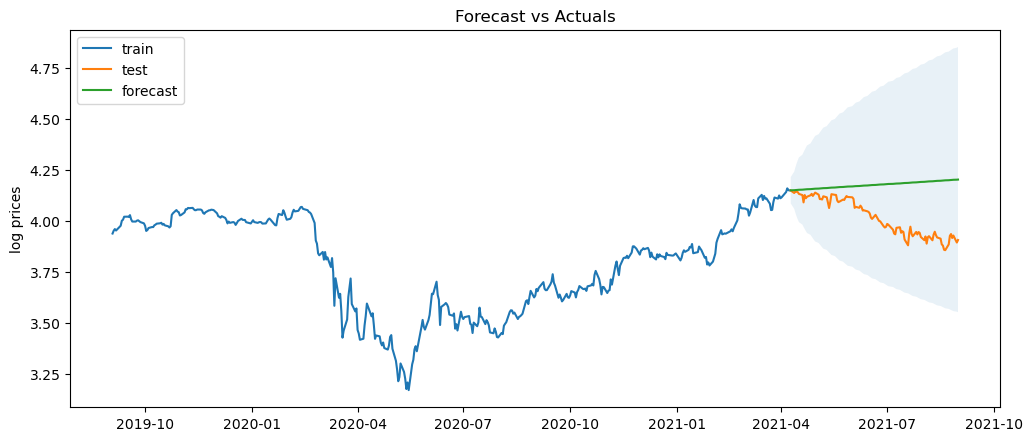

In [117]:
forecast, se, conf = ARIMA010.forecast(101, alpha = 0.05)
forecast = pd.Series(forecast, index=test_log.index)
lower_series = pd.Series(conf[:, 0], index=test_log.index)
upper_series = pd.Series(conf[:, 1], index=test_log.index)

plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_log, label='train')
plt.plot(test_log, label='test')
plt.plot(forecast, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, alpha=.1)
plt.title('Forecast vs Actuals')
plt.ylabel('log prices')
plt.legend(loc='upper left')
plt.show()

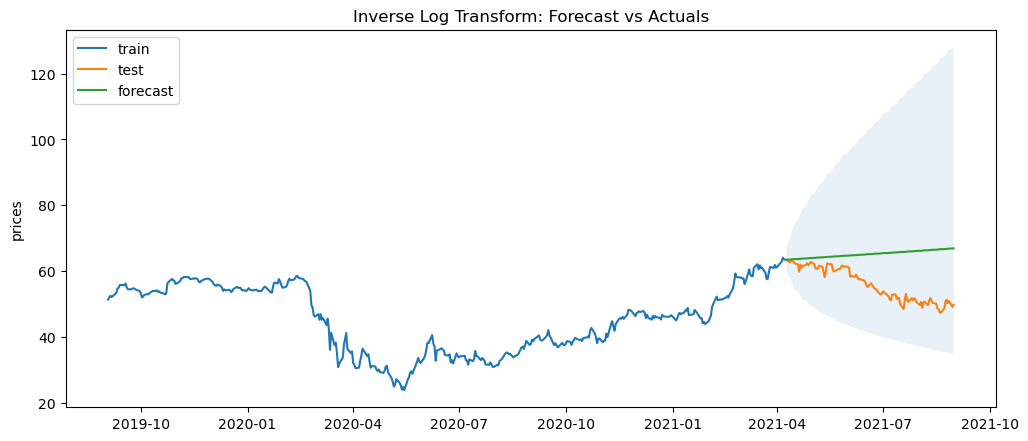

In [129]:
forecast, se, conf = ARIMA010.forecast(101, alpha = 0.05)
forecast = pd.Series(forecast, index=test_log.index)
forecast = np.exp(forecast)
se = np.exp(se)
conf = np.exp(conf)
lower_series = pd.Series(conf[:, 0], index=test_log.index)
upper_series = pd.Series(conf[:, 1], index=test_log.index)

plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='train')
plt.plot(test, label='test')
plt.plot(forecast, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, alpha=.1)
plt.title('Inverse Log Transform: Forecast vs Actuals')
plt.ylabel('prices')
plt.legend(loc='upper left')
plt.show()

# LSTM

In [135]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras 
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [136]:
data = SW.filter(['Close'])
dataset = data.values

In [137]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data.shape

(504, 1)

In [138]:
training_data_len = int(np.ceil(len(dataset) * .8 ))
training_data_len

404

In [139]:
train_data = scaled_data[0:int(training_data_len), :]
x_train = []
y_train = []

for i in range(10, len(train_data)):
    x_train.append(train_data[i-10:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 11:
        print(x_train)
        print(y_train)
        print()
        
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

[array([0.68381809, 0.70171512, 0.71215514, 0.70270943, 0.72607514,
       0.73353224, 0.7665921 , 0.77330352, 0.79343778, 0.79393493])]
[0.7919463230436222]

[array([0.68381809, 0.70171512, 0.71215514, 0.70270943, 0.72607514,
       0.73353224, 0.7665921 , 0.77330352, 0.79343778, 0.79393493]), array([0.70171512, 0.71215514, 0.70270943, 0.72607514, 0.73353224,
       0.7665921 , 0.77330352, 0.79343778, 0.79393493, 0.79194632])]
[0.7919463230436222, 0.8043748596927617]



In [140]:
x_train.shape

(394, 10, 1)

In [141]:
# Create the testing data set
# Create a new array containing scaled values from index 1543 to 2002 
test_data = scaled_data[training_data_len - 10: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(10, len(test_data)):
    x_test.append(test_data[i-10:i, 0])
    
# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

## Mean squared error

In [142]:
model = Sequential()
model.add(LSTM(4, input_shape= (x_train.shape[1], 1)))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=256, epochs=100, verbose=2)

Epoch 1/100
2/2 - 2s - loss: 0.6498 - 2s/epoch - 937ms/step
Epoch 2/100
2/2 - 0s - loss: 0.6291 - 10ms/epoch - 5ms/step
Epoch 3/100
2/2 - 0s - loss: 0.6090 - 9ms/epoch - 5ms/step
Epoch 4/100
2/2 - 0s - loss: 0.5890 - 10ms/epoch - 5ms/step
Epoch 5/100
2/2 - 0s - loss: 0.5695 - 8ms/epoch - 4ms/step
Epoch 6/100
2/2 - 0s - loss: 0.5501 - 11ms/epoch - 6ms/step
Epoch 7/100
2/2 - 0s - loss: 0.5311 - 9ms/epoch - 5ms/step
Epoch 8/100
2/2 - 0s - loss: 0.5123 - 10ms/epoch - 5ms/step
Epoch 9/100
2/2 - 0s - loss: 0.4939 - 10ms/epoch - 5ms/step
Epoch 10/100
2/2 - 0s - loss: 0.4757 - 11ms/epoch - 6ms/step
Epoch 11/100
2/2 - 0s - loss: 0.4580 - 10ms/epoch - 5ms/step
Epoch 12/100
2/2 - 0s - loss: 0.4404 - 9ms/epoch - 5ms/step
Epoch 13/100
2/2 - 0s - loss: 0.4232 - 10ms/epoch - 5ms/step
Epoch 14/100
2/2 - 0s - loss: 0.4064 - 10ms/epoch - 5ms/step
Epoch 15/100
2/2 - 0s - loss: 0.3900 - 10ms/epoch - 5ms/step
Epoch 16/100
2/2 - 0s - loss: 0.3735 - 12ms/epoch - 6ms/step
Epoch 17/100
2/2 - 0s - loss: 0.3577 

In [143]:
# Get the models predicted price values 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse  #Test RMSE

5.173020608162693

In [144]:
predictions1 = model.predict(x_train)
rmse = np.sqrt(np.mean(((predictions1 - y_train) ** 2)))
rmse     #Train RMSE

0.2833863343490472

In [145]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
valid

<ipython-input-145-fb6554dbe6ad>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


,Close,Predictions
Date,,
2021-04-12,62.660000,54.129566
2021-04-13,63.230000,54.123581
2021-04-14,63.029999,54.232426
2021-04-15,62.939999,54.248920
2021-04-16,62.389999,54.280796
...,...,...
2021-08-25,51.250000,48.453751
2021-08-26,50.270000,48.450520
2021-08-27,50.880001,48.410061


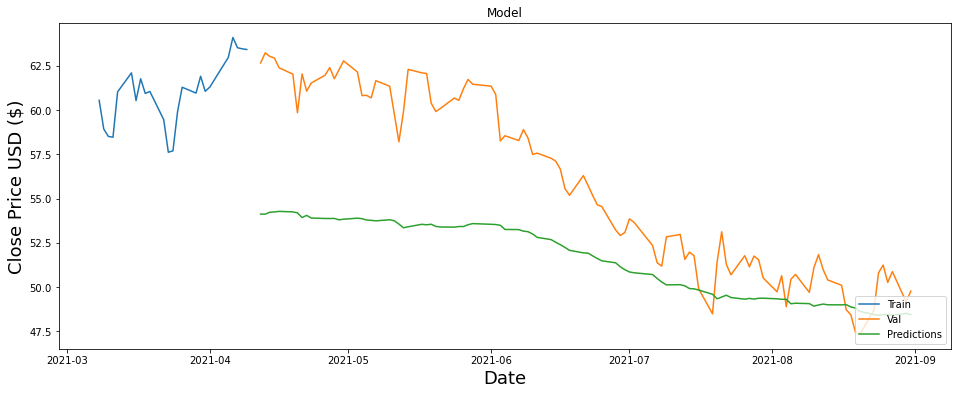

In [146]:
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'][380:])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [147]:
model = Sequential()
model.add(LSTM(4, input_shape= (x_train.shape[1], 1)))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
#rt = model.fit(x_train, y_train, batch_size=256, epochs=100, verbose=2)
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=256, epochs=100, verbose=2)

Epoch 1/100
2/2 - 2s - loss: 0.5579 - val_loss: 3161.8369 - 2s/epoch - 765ms/step
Epoch 2/100
2/2 - 0s - loss: 0.5423 - val_loss: 3160.3706 - 27ms/epoch - 13ms/step
Epoch 3/100
2/2 - 0s - loss: 0.5271 - val_loss: 3158.9456 - 27ms/epoch - 14ms/step
Epoch 4/100
2/2 - 0s - loss: 0.5127 - val_loss: 3157.5613 - 26ms/epoch - 13ms/step
Epoch 5/100
2/2 - 0s - loss: 0.4989 - val_loss: 3156.2180 - 25ms/epoch - 13ms/step
Epoch 6/100
2/2 - 0s - loss: 0.4860 - val_loss: 3154.9170 - 25ms/epoch - 13ms/step
Epoch 7/100
2/2 - 0s - loss: 0.4732 - val_loss: 3153.6611 - 25ms/epoch - 12ms/step
Epoch 8/100
2/2 - 0s - loss: 0.4613 - val_loss: 3152.4465 - 26ms/epoch - 13ms/step
Epoch 9/100
2/2 - 0s - loss: 0.4497 - val_loss: 3151.2737 - 24ms/epoch - 12ms/step
Epoch 10/100
2/2 - 0s - loss: 0.4389 - val_loss: 3150.1387 - 26ms/epoch - 13ms/step
Epoch 11/100
2/2 - 0s - loss: 0.4283 - val_loss: 3149.0420 - 25ms/epoch - 13ms/step
Epoch 12/100
2/2 - 0s - loss: 0.4183 - val_loss: 3147.9797 - 25ms/epoch - 13ms/step
Ep

Epoch 99/100
2/2 - 0s - loss: 0.0315 - val_loss: 3066.0532 - 32ms/epoch - 16ms/step
Epoch 100/100
2/2 - 0s - loss: 0.0308 - val_loss: 3065.9443 - 33ms/epoch - 16ms/step


13/13 - 0s - loss: 0.0303 - 349ms/epoch - 27ms/step
4/4 - 0s - loss: 3065.9446 - 19ms/epoch - 5ms/step
Train: 0.030, Test: 3065.945


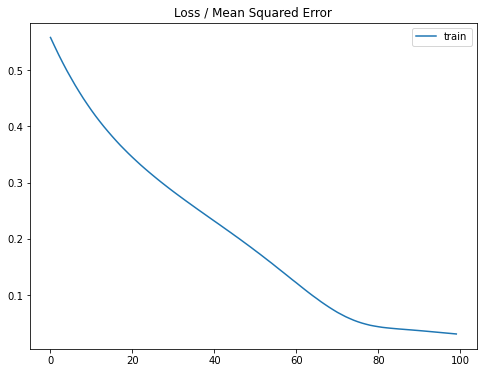

In [148]:
train_mse = model.evaluate(x_train, y_train, verbose=2)
test_mse = model.evaluate(x_test, y_test, verbose=2)
print('Train: %.3f, Test: %.3f' % (train_mse, test_mse))
# plot loss during training
plt.title('Loss / Mean Squared Error')
plt.plot(history.history['loss'], label='train')
#plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## Use another model (perform better)

In [184]:
from tensorflow.keras.optimizers import SGD
model = Sequential()

#model.add(LSTM(4, input_shape= (x_train.shape[1], 1)))
#model.add(Dense(1))

model.add(LSTM(4, input_shape= (x_train.shape[1], 1)))
model.add(Dense(1))

opt = SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss='mean_squared_error', optimizer=opt)
# fit model
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100, verbose=0)
# evaluate the model
train_mse = model.evaluate(x_train, y_train, verbose=0)
print('Train:', train_mse)
#test_mse = model.evaluate(x_test, y_test, verbose=0)
#print('Train: %.3f, Test: %.3f' % (train_mse, test_mse))

Train: 0.0018758713267743587


In [152]:
# Get the models predicted price values 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the mean squared error (RMSE)
test_mse = np.mean(((predictions - y_test) ** 2))

predictions1 = model.predict(x_train)
train_mse = np.mean(((predictions1 - y_train) ** 2))

print('Train: %.3f, Test: %.3f' % (train_mse, test_mse))

Train: 0.127, Test: 1.378


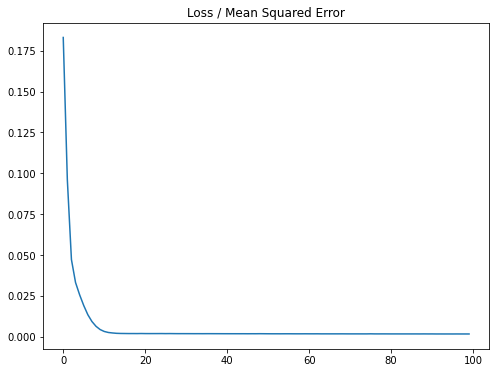

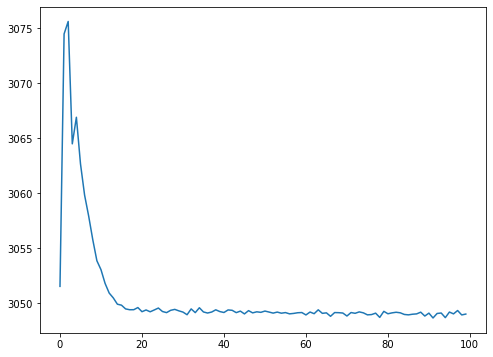

In [180]:
# plot loss during training
plt.title('Loss / Mean Squared Error')
plt.plot(history.history['loss'], label='train')
plt.show()

plt.plot(history.history['val_loss'], label='test')
plt.show()

In [64]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
valid

<ipython-input-64-ab8bfd39287d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


,Close,Predictions
Date,,
2021-04-12,62.660000,61.475773
2021-04-13,63.230000,61.413017
2021-04-14,63.029999,61.423141
2021-04-15,62.939999,61.422878
2021-04-16,62.389999,61.403725
...,...,...
2021-08-25,51.250000,49.584793
2021-08-26,50.270000,50.277931
2021-08-27,50.880001,50.427326


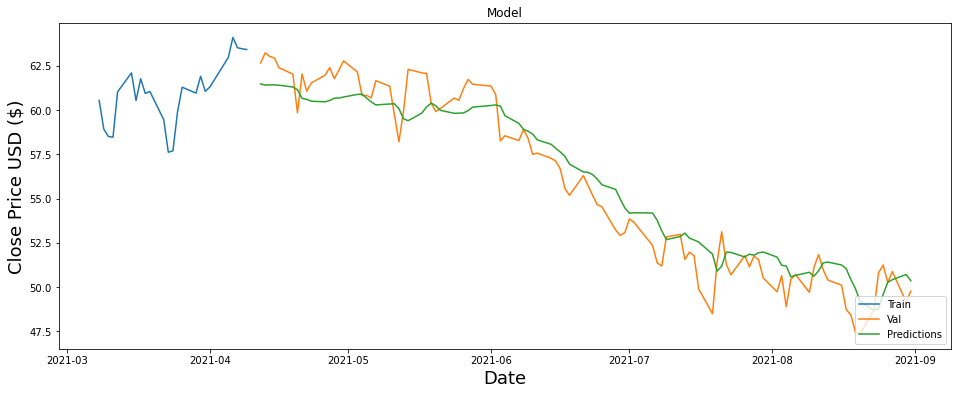

In [65]:
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'][380:])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

# Netflix

In [66]:
#NF
#nf
#nf_rtn
lognf = np.log(nf).dropna() #only log transform
dnf = nf.diff().dropna() #only difference
lognf

Date
2019-09-03    5.667430
2019-09-04    5.675109
2019-09-05    5.681025
2019-09-06    5.670467
2019-09-09    5.684736
                ...   
2021-08-25    6.305509
2021-08-26    6.310136
2021-08-27    6.326006
2021-08-30    6.338912
2021-08-31    6.344214
Name: Close, Length: 504, dtype: float64

## Differencing

In [67]:
from statsmodels.tsa.stattools import adfuller  # original data
result = adfuller(nf.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])   #P-value is greater than the significance level, need difference

ADF Statistic: -1.390497
p-value: 0.586823


In [68]:
result = adfuller(lognf.dropna())  # log transformed data
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])   #P-value is greater than the significance level, still need difference

ADF Statistic: -1.474680
p-value: 0.545997


In [69]:
result = adfuller(nf_rtn.dropna())  # 1st differencing
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])   #P-value almost 0, difference once is enough

ADF Statistic: -8.517508
p-value: 0.000000


## ARIMA

In [70]:
best_model = arma_order_select_ic(nf_rtn, max_ar = 3, max_ma =3, ic=['aic', 'bic'])
print('AIC Best: ',best_model.aic_min_order)
print('BIC Best: ',best_model.bic_min_order)

AIC Best:  (2, 2)
BIC Best:  (1, 0)


### ARIMA(2,1,2)

In [71]:
model = ARIMA(lognf, order=(2,1,2))
ARIMA212 = model.fit()
print(ARIMA212.summary())

C:\Users\11638\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\11638\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  503
Model:                 ARIMA(2, 1, 2)   Log Likelihood                1152.060
Method:                       css-mle   S.D. of innovations              0.024
Date:                Mon, 13 Dec 2021   AIC                          -2292.120
Time:                        01:40:32   BIC                          -2266.797
Sample:                             1   HQIC                         -2282.186
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0013      0.000      2.763      0.006       0.000       0.002
ar.L1.D.Close     0.2825      0.155      1.823      0.068      -0.021       0.586
ar.L2.D.Close     0.5650      0.129     

### ARIMA(1,1,0)    Seems the best

In [72]:
model = ARIMA(lognf, order=(1,1,0))
ARIMA110 = model.fit()
print(ARIMA110.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  503
Model:                 ARIMA(1, 1, 0)   Log Likelihood                1147.919
Method:                       css-mle   S.D. of innovations              0.025
Date:                Mon, 13 Dec 2021   AIC                          -2289.838
Time:                        01:40:33   BIC                          -2277.177
Sample:                             1   HQIC                         -2284.871
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0013      0.001      1.465      0.143      -0.000       0.003
ar.L1.D.Close    -0.2022      0.044     -4.635      0.000      -0.288      -0.117
                                    Root

C:\Users\11638\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\11638\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


### ARIMA(0,1,0)

In [73]:
model = ARIMA(lognf, order=(0,1,0))
ARIMA010 = model.fit()
print(ARIMA010.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  503
Model:                 ARIMA(0, 1, 0)   Log Likelihood                1137.402
Method:                           css   S.D. of innovations              0.025
Date:                Mon, 13 Dec 2021   AIC                          -2270.804
Time:                        01:40:33   BIC                          -2262.363
Sample:                             1   HQIC                         -2267.492
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.001      1.197      0.231      -0.001       0.004


C:\Users\11638\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\11638\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


#### ARIMA best model selected is ARIMA(1,1,0)

## Prediction

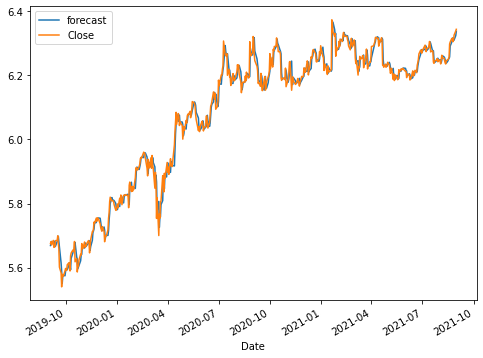

In [74]:
#plt.rcParams["figure.figsize"]=(18,8)
ARIMA110.plot_predict(dynamic=False)
plt.show()

In [75]:
lastIdx = len(ARIMA110.fittedvalues)
print(lastIdx)

503


C:\Users\11638\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\11638\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\11638\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


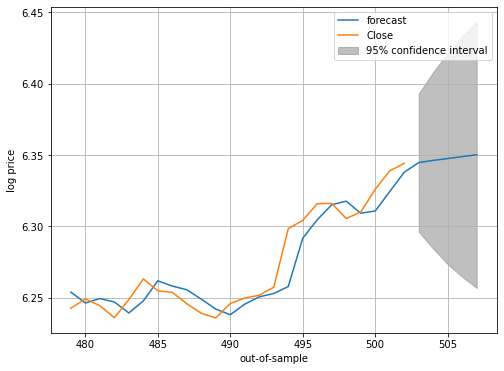

In [76]:
ARIMA110.plot_predict(start=480,end=508)
plt.grid()
plt.xlabel('out-of-sample')
plt.ylabel('log price')
plt.show()         # the forecast plot is on log transformed data

In [77]:
start_date = '2021-08-20'
end_date = '2021-9-08'
nf_FC = yf.download("NFLX", start_date , end_date) 

[*********************100%***********************]  1 of 1 completed


In [78]:
nf_logfc = np.log(nf_FC['Close']).dropna()

Text(0.5, 1.0, 'Actual (log) Prices for out-of-sample of Netflix')

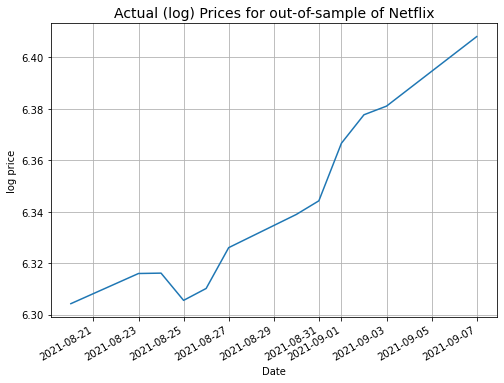

In [79]:
nf_logfc.plot()
plt.grid()
plt.ylabel("log price")
plt.title("Actual (log) Prices for out-of-sample of Netflix", fontsize = 14)

### The out of sample prediction did predict the trend correctly using ARIMA(1,1,0)

## Train Test Slip

In [185]:
nf

Date
2019-09-03    289.290009
2019-09-04    291.519989
2019-09-05    293.250000
2019-09-06    290.170013
2019-09-09    294.339996
                 ...    
2021-08-25    547.580017
2021-08-26    550.119995
2021-08-27    558.919983
2021-08-30    566.179993
2021-08-31    569.190002
Name: Close, Length: 504, dtype: float64

In [187]:
train = nf.iloc[:403]
test = nf.iloc[403:]

## Select ARIMA model

In [188]:
train_rtn1 = np.log(train).diff().dropna()
test_rtn1 = np.log(test).diff().dropna()

In [189]:
best_model = arma_order_select_ic(train_rtn1, max_ar = 3, max_ma =3, ic=['aic', 'bic'])
print('AIC Best: ',best_model.aic_min_order)
print('BIC Best: ',best_model.bic_min_order)

C:\Users\11638\anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:218: RuntimeWarning: divide by zero encountered in true_divide
  loglike, sigma2 = kalman_loglike.kalman_loglike_double(
C:\Users\11638\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\11638\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\11638\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\11638\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()


AIC Best:  (2, 2)
BIC Best:  (1, 0)


### ARIMA(2,1,2) on log transformed data

In [190]:
train_log = np.log(train).dropna()
test_log = np.log(test).dropna()

In [191]:
model = ARIMA(train_log, order=(2,1,2))
ARIMA212 = model.fit()
print(ARIMA212.summary())

C:\Users\11638\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\11638\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  402
Model:                 ARIMA(2, 1, 2)   Log Likelihood                 891.200
Method:                       css-mle   S.D. of innovations              0.026
Date:                Mon, 13 Dec 2021   AIC                          -1770.401
Time:                        13:58:11   BIC                          -1746.422
Sample:                             1   HQIC                         -1760.907
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0017      0.000      3.657      0.000       0.001       0.003
ar.L1.D.Close     0.2742      0.162      1.693      0.090      -0.043       0.592
ar.L2.D.Close     0.5750      0.135     

### ARIMA(1,1,0) on log transformed data

In [192]:
model = ARIMA(train_log, order=(1,1,0))
ARIMA110 = model.fit()
print(ARIMA110.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  402
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 886.711
Method:                       css-mle   S.D. of innovations              0.027
Date:                Mon, 13 Dec 2021   AIC                          -1767.422
Time:                        13:59:30   BIC                          -1755.433
Sample:                             1   HQIC                         -1762.675
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0016      0.001      1.471      0.141      -0.001       0.004
ar.L1.D.Close    -0.2142      0.049     -4.403      0.000      -0.310      -0.119
                                    Root

C:\Users\11638\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\11638\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


#### ARIMA(1,1,0) should be enough

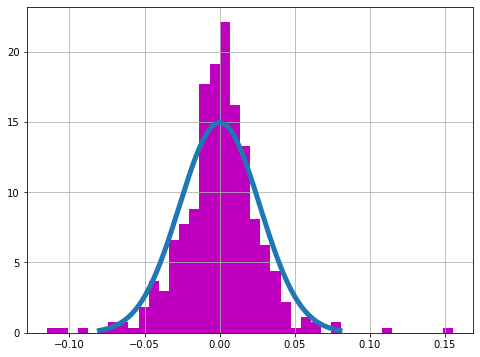

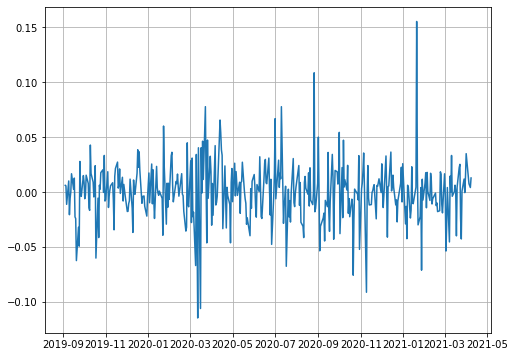

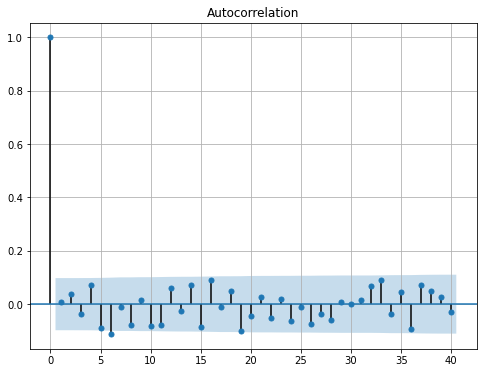

In [195]:
resid = ARIMA110.resid
plt.hist(resid, bins =40,color='m', density = True)
mu = resid.mean()
sigma = resid.std()
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 2419)
plt.plot(x, stats.norm.pdf(x, mu, sigma), linewidth= 5)
plt.grid()
plt.show()
plt.plot(resid)
plt.grid()
plt.show()
plot_acf(resid,lags=40,zero=True)
plt.grid()
plt.show()

## Prediction using ARIMA(1,1,0)

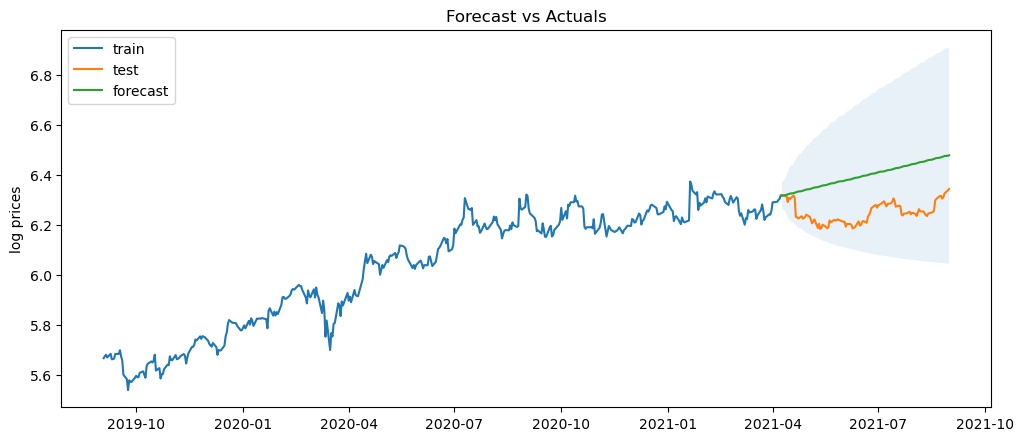

In [193]:
forecast, se, conf = ARIMA110.forecast(101, alpha = 0.05)
forecast = pd.Series(forecast, index=test_log.index)
lower_series = pd.Series(conf[:, 0], index=test_log.index)
upper_series = pd.Series(conf[:, 1], index=test_log.index)

plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_log, label='train')
plt.plot(test_log, label='test')
plt.plot(forecast, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, alpha=.1)
plt.title('Forecast vs Actuals')
plt.ylabel('log prices')
plt.legend(loc='upper left')
plt.show()

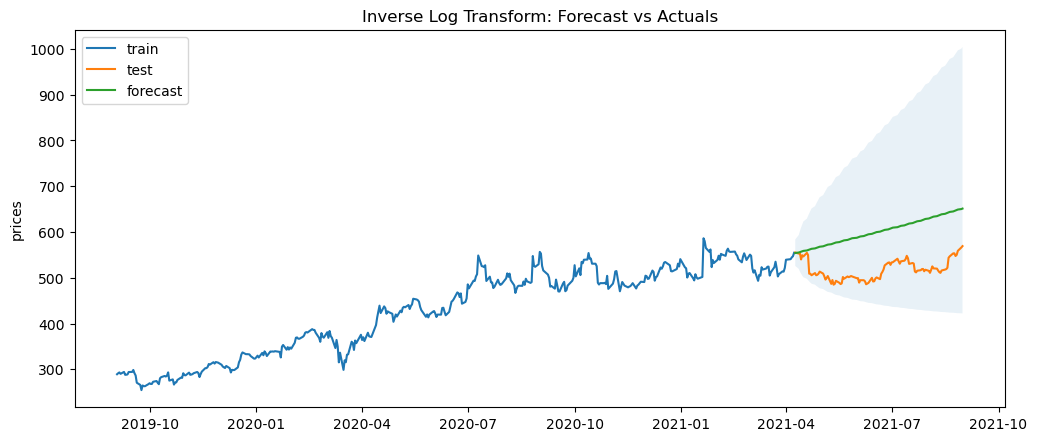

In [194]:
forecast, se, conf = ARIMA110.forecast(101, alpha = 0.05)
forecast = pd.Series(forecast, index=test_log.index)
forecast = np.exp(forecast)
se = np.exp(se)
conf = np.exp(conf)
lower_series = pd.Series(conf[:, 0], index=test_log.index)
upper_series = pd.Series(conf[:, 1], index=test_log.index)

plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='train')
plt.plot(test, label='test')
plt.plot(forecast, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, alpha=.1)
plt.title('Inverse Log Transform: Forecast vs Actuals')
plt.ylabel('prices')
plt.legend(loc='upper left')
plt.show()

## LSTM

In [196]:
data = NF.filter(['Close'])
dataset = data.values
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data.shape

(504, 1)

In [197]:
training_data_len = int(np.ceil(len(dataset) * .8 ))
training_data_len

404

In [198]:
train_data = scaled_data[0:int(training_data_len), :]
x_train = []
y_train = []

for i in range(10, len(train_data)):
    x_train.append(train_data[i-10:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 11:
        print(x_train)
        print(y_train)
        print()
        
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

[array([0.10459686, 0.11131873, 0.11653353, 0.10724948, 0.11981913,
       0.10067819, 0.1015222 , 0.10330064, 0.1192464 , 0.11966845])]
[0.1326601528776441]

[array([0.10459686, 0.11131873, 0.11653353, 0.10724948, 0.11981913,
       0.10067819, 0.1015222 , 0.10330064, 0.1192464 , 0.11966845]), array([0.11131873, 0.11653353, 0.10724948, 0.11981913, 0.10067819,
       0.1015222 , 0.10330064, 0.1192464 , 0.11966845, 0.13266015])]
[0.1326601528776441, 0.11143933027835617]



In [199]:
# Create the testing data set
# Create a new array containing scaled values from index 1543 to 2002 
test_data = scaled_data[training_data_len - 10: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(10, len(test_data)):
    x_test.append(test_data[i-10:i, 0])
    
# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

## model1

In [204]:
from tensorflow.keras.optimizers import SGD
model = Sequential()

#model.add(LSTM(4, input_shape= (x_train.shape[1], 1)))
#model.add(Dense(1))

model.add(LSTM(4, input_shape= (x_train.shape[1], 1)))
model.add(Dense(1))

opt = SGD(learning_rate=0.02, momentum=0.9)
model.compile(loss='mean_squared_error', optimizer=opt)
# fit model
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100, verbose=0)
# evaluate the model
train_mse = model.evaluate(x_train, y_train, verbose=0)
#test_mse = model.evaluate(x_test, y_test, verbose=0)
train_mse

0.0019351288210600615

In [205]:
# Get the models predicted price values 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the mean squared error (RMSE)
test_mse = np.mean(((predictions - y_test) ** 2))

predictions1 = model.predict(x_train)
train_mse = np.mean(((predictions1 - y_train) ** 2))
print('Train: %.3f, Test: %.3f' % (train_mse, test_mse))

Train: 0.149, Test: 112.625


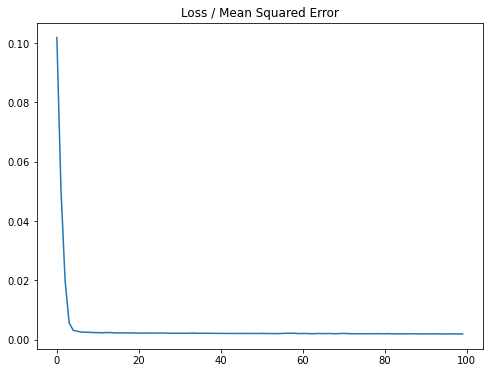

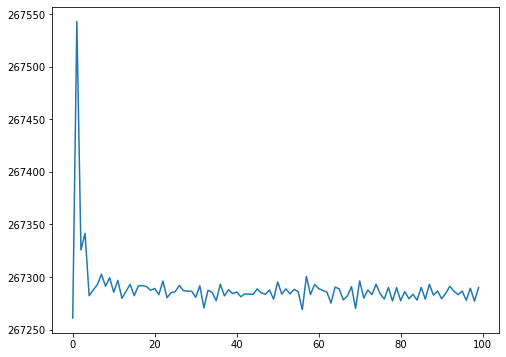

In [206]:
# plot loss during training
plt.title('Loss / Mean Squared Error')
plt.plot(history.history['loss'], label='train')
#plt.plot(history.history['val_loss'], label='test')
#plt.legend()
plt.show()

plt.plot(history.history['val_loss'], label='test')
plt.show()

In [208]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

<ipython-input-208-adbaaaac3682>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


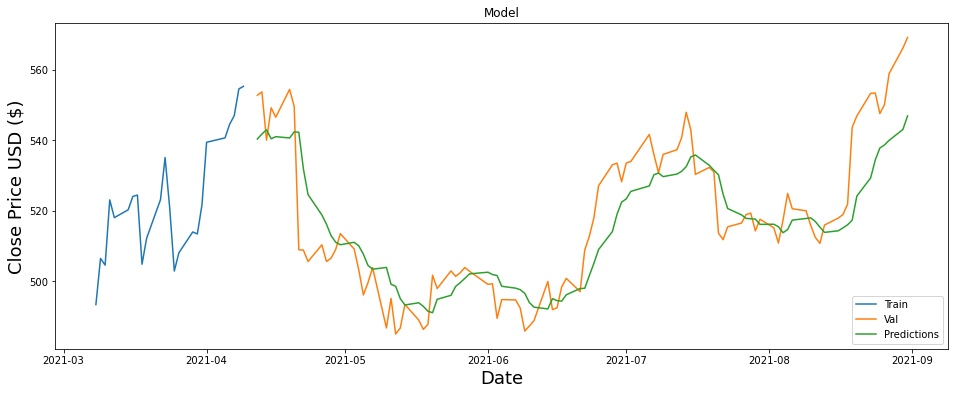

In [209]:
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'][380:])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

### Best 

In [216]:
model = Sequential()

#model.add(LSTM(4, input_shape= (x_train.shape[1], 1)))
#model.add(Dense(1))

model.add(LSTM(4, input_shape= (x_train.shape[1], 1)))
model.add(Dense(1))

opt = SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss='mean_squared_error', optimizer=opt)
# fit model
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100, verbose=0)
# evaluate the model
train_loss = model.evaluate(x_train, y_train, verbose=0)
#test_mse = model.evaluate(x_test, y_test, verbose=0)
print(train_loss)

# Get the models predicted price values 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the mean squared error (RMSE)
test_mse = np.mean(((predictions - y_test) ** 2))

predictions1 = model.predict(x_train)
train_mse = np.mean(((predictions1 - y_train) ** 2))
print('Train: %.3f, Test: %.3f' % (train_mse, test_mse))

0.001833692891523242
Train: 0.150, Test: 106.080


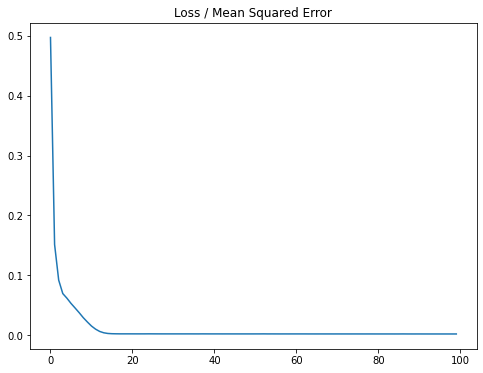

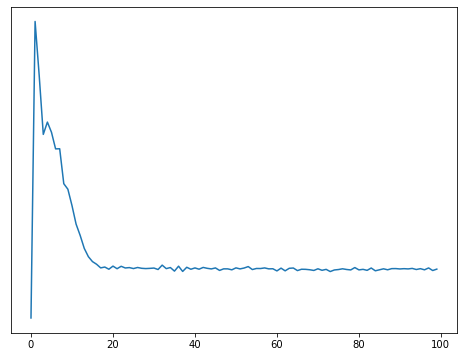

In [218]:
# plot loss during training
plt.title('Loss / Mean Squared Error')
plt.plot(history.history['loss'], label='train')
#plt.plot(history.history['val_loss'], label='test')
#plt.legend()
plt.show()

plt.plot(history.history['val_loss'], label='test')
plt.yticks([])
plt.show()

<ipython-input-213-571b008f5623>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


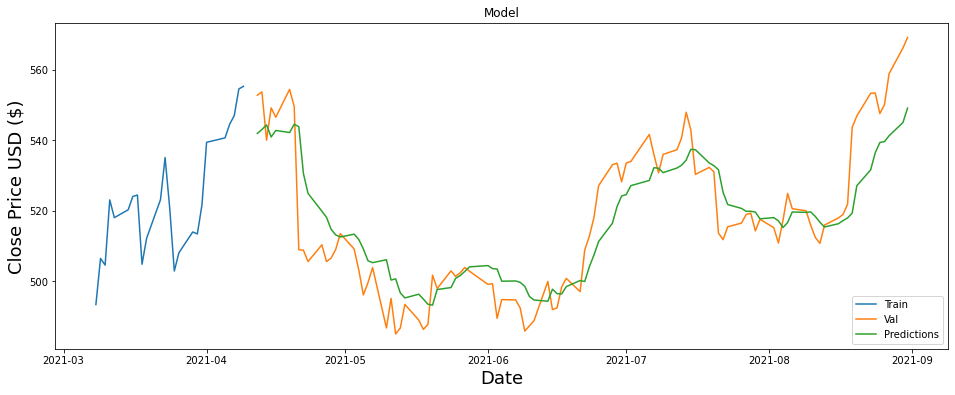

In [213]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'][380:])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

### Model3

In [214]:
model = Sequential()
model.add(LSTM(4, input_shape= (x_train.shape[1], 1)))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
#model.fit(x_train, y_train, batch_size=256, epochs=100, verbose=2)
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100, verbose=0)
# evaluate the model
train_loss = model.evaluate(x_train, y_train, verbose=0)
#test_mse = model.evaluate(x_test, y_test, verbose=0)
print(train_loss)

# Get the models predicted price values 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the mean squared error (RMSE)
test_mse = np.mean(((predictions - y_test) ** 2))

predictions1 = model.predict(x_train)
train_mse = np.mean(((predictions1 - y_train) ** 2))
print('Train: %.3f, Test: %.3f' % (train_mse, test_mse))

0.0024553886614739895
Train: 0.149, Test: 161.033
